In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


✅ All files loaded successfully!
✅ KBO data 'Year' format corrected.

✅ PCA Component 1 Weights:
   - IsoP: -0.3671
   - EV: 0.4649
   - BB_per_K: -0.1021
   - ERA: -0.4080
   - FAv: 0.5650
   - K_minus_BB_pct: 0.3911


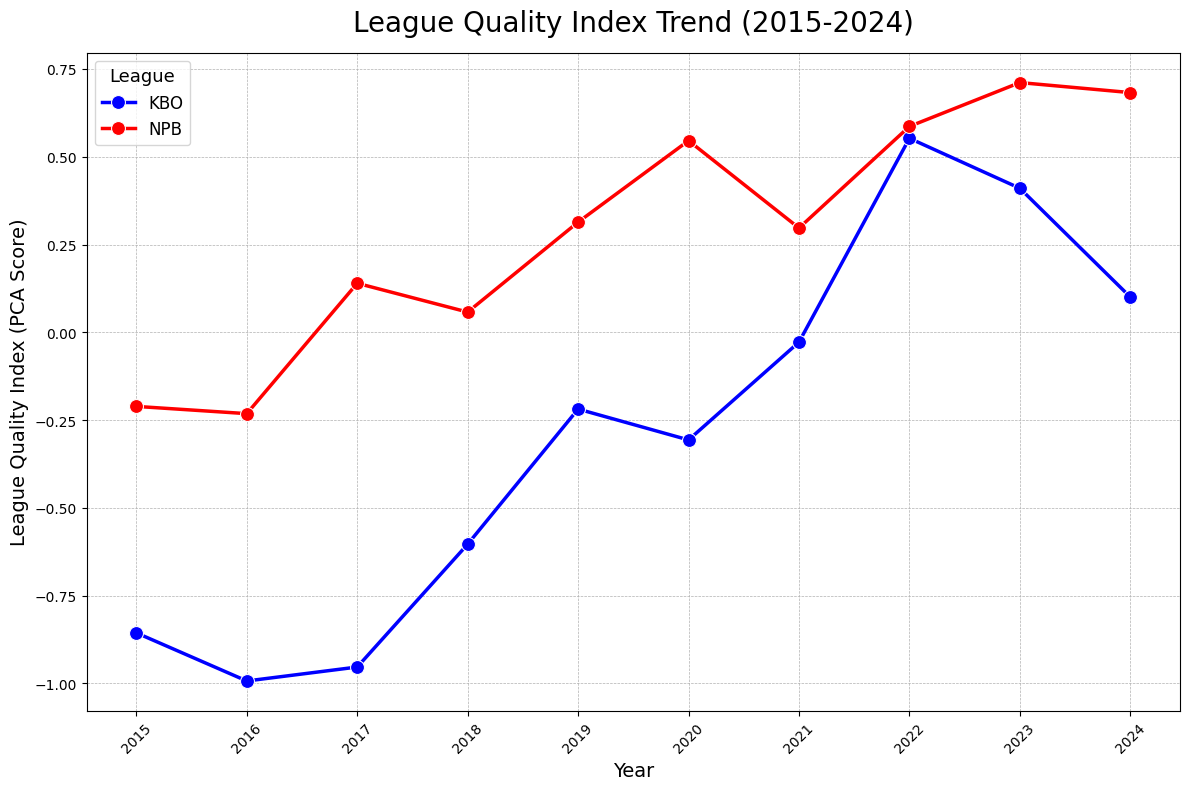

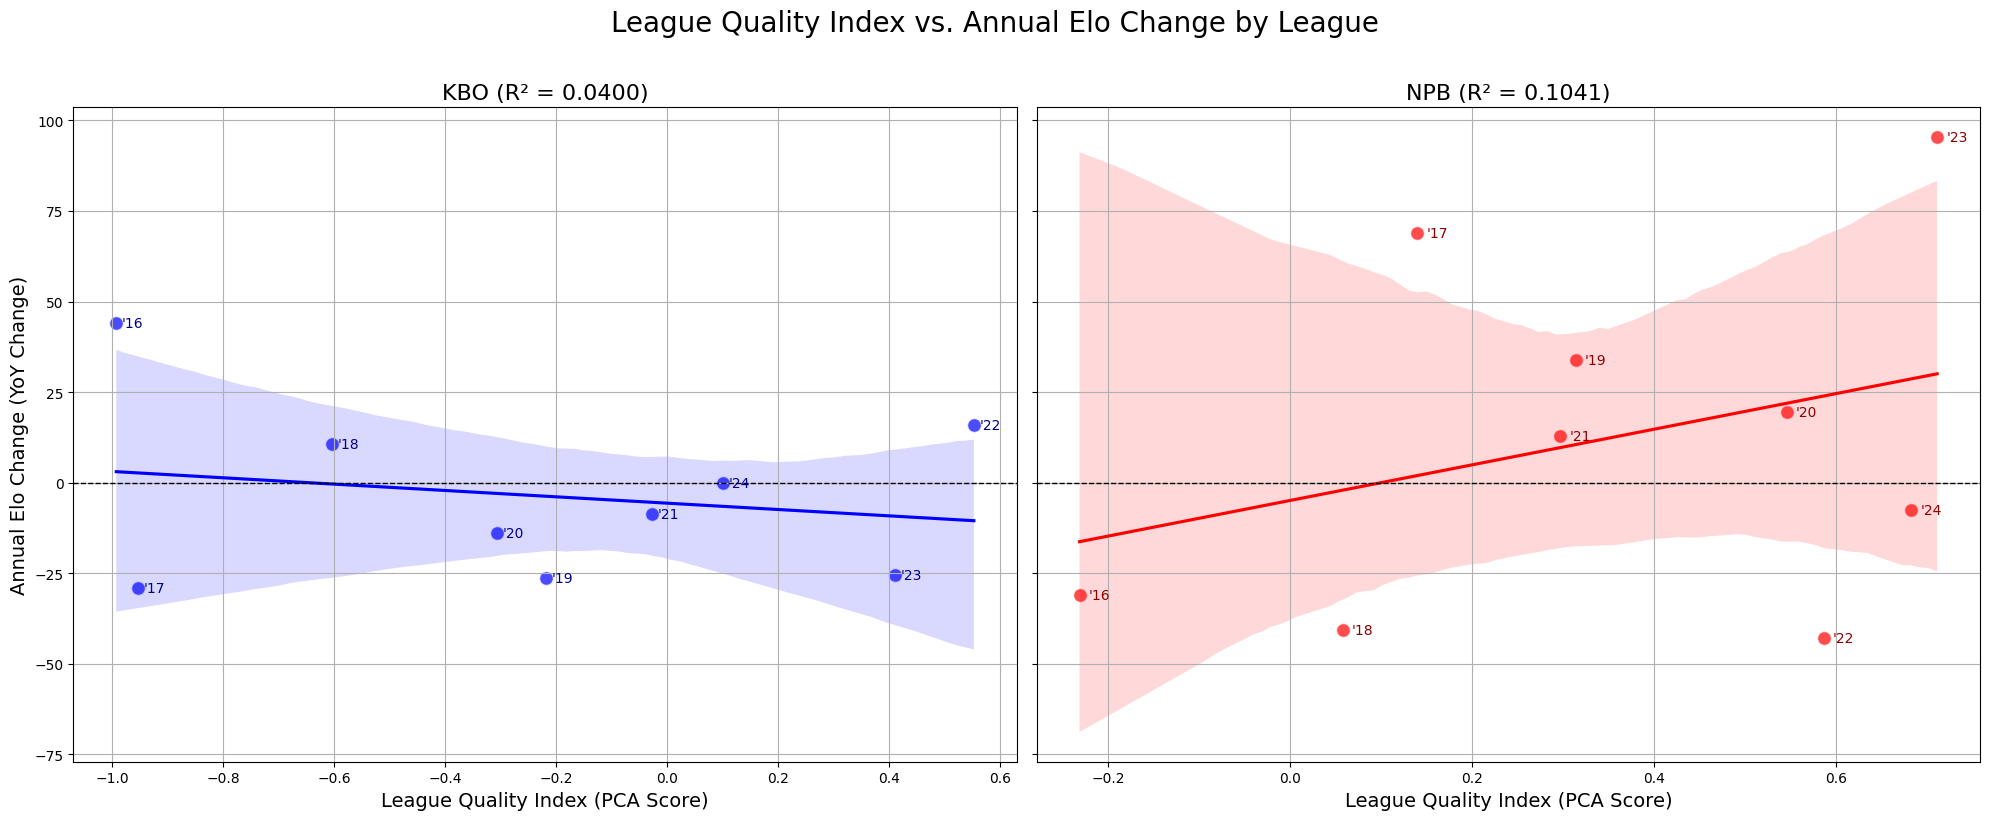


✅ All plots and analyses completed successfully.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
from sklearn.linear_model import LinearRegression

# --- Font setting logic removed ---

def correct_year(year):
    """Converts a two-digit year to a four-digit year."""
    if isinstance(year, str):
        try:
            year = int(year)
        except ValueError:
            return None
    if 0 <= year <= 99:
        return 2000 + year if year < 30 else 1900 + year
    return year

def load_and_clean_data():
    """Loads all CSV files from Google Drive and performs basic cleaning."""
    try:
        # 이 부분은 실제 파일 경로에 맞게 수정해야 합니다.
        base_path = "/content/drive/MyDrive/Untitled Folder/"
        npb_bat = pd.read_csv(base_path + 'NPB_타격_05-24.csv')
        npb_pitch = pd.read_csv(base_path + 'NPB_투구_05-24.csv')
        kbo_bat = pd.read_csv(base_path + 'KBO_타격_05-24_규정 - Listly (free plan).csv')
        kbo_pitch = pd.read_csv(base_path + 'KBO_투구_05-24_규정 - Listly (free plan).csv')
        kbo_ev = pd.read_csv(base_path + 'KBO_타격_ev.csv')
        kbo_fav = pd.read_csv(base_path + 'KBO_투구_FAv.csv')
        elo_df = pd.read_csv(base_path + 'elo_history1.csv')
        print("✅ All files loaded successfully!")
        for df in [kbo_bat, kbo_pitch, kbo_ev, kbo_fav]:
            if 'Year' in df.columns:
                df['Year'] = df['Year'].apply(correct_year)
        print("✅ KBO data 'Year' format corrected.")
        return npb_bat, npb_pitch, kbo_bat, kbo_pitch, kbo_ev, kbo_fav, elo_df
    except FileNotFoundError as e:
        print(f"❌ File Error: {e}")
        # 파일 로드 실패 시, 분석 중단을 위해 빈 데이터프레임 반환
        return [pd.DataFrame() for _ in range(7)]

def process_league_data(npb_bat, npb_pitch, kbo_bat, kbo_pitch, kbo_ev, kbo_fav):
    """Calculates and merges annual average league stats."""
    # NPB Data Processing
    npb_bat_1524 = npb_bat[npb_bat['Year'] >= 2015].copy()
    npb_pitch_1524 = npb_pitch[npb_pitch['Year'] >= 2015].copy()
    for col in ['IsoP', 'ev', 'BB/K']:
        npb_bat_1524[col] = pd.to_numeric(npb_bat_1524[col], errors='coerce')
    for col in ['ERA', 'FAv', 'K-BB%']:
        npb_pitch_1524[col] = pd.to_numeric(npb_pitch_1524[col], errors='coerce')
    npb_bat_agg = npb_bat_1524.groupby('Year').agg(IsoP=('IsoP', 'mean'), EV=('ev', 'mean'), BB_per_K=('BB/K', 'mean')).reset_index()
    npb_pitch_agg = npb_pitch_1524.groupby('Year').agg(ERA=('ERA', 'mean'), FAv=('FAv', 'mean'), K_minus_BB_pct=('K-BB%', 'mean')).reset_index()
    npb_avg = pd.merge(npb_bat_agg, npb_pitch_agg, on='Year')
    npb_avg['League'] = 'NPB'

    # KBO Data Processing
    kbo_bat_1524 = kbo_bat[kbo_bat['Year'] >= 2015].copy()
    kbo_pitch_1524 = kbo_pitch[kbo_pitch['Year'] >= 2015].copy()
    kbo_ev_1524 = kbo_ev[kbo_ev['Year'] >= 2015].copy()
    kbo_fav_1524 = kbo_fav[kbo_fav['Year'] >= 2015].copy()
    for col in ['IsoP', 'BB/K']:
        kbo_bat_1524[col] = pd.to_numeric(kbo_bat_1524[col], errors='coerce')
    for col in ['ERA', 'K-BB%']:
        kbo_pitch_1524[col] = pd.to_numeric(kbo_pitch_1524[col], errors='coerce')
    kbo_ev_1524['ev'] = pd.to_numeric(kbo_ev_1524['ev'], errors='coerce')
    kbo_fav_1524['FAv'] = pd.to_numeric(kbo_fav_1524['FAv'], errors='coerce')
    kbo_bat_agg_main = kbo_bat_1524.groupby('Year').agg(IsoP=('IsoP', 'mean'), BB_per_K=('BB/K', 'mean')).reset_index()
    kbo_pitch_agg_main = kbo_pitch_1524.groupby('Year').agg(ERA=('ERA', 'mean'), K_minus_BB_pct=('K-BB%', 'mean')).reset_index()
    kbo_ev_agg = kbo_ev_1524.groupby('Year').agg(EV=('ev', 'mean')).reset_index()
    kbo_fav_agg = kbo_fav_1524.groupby('Year').agg(FAv=('FAv', 'mean')).reset_index()
    kbo_dfs = [kbo_bat_agg_main, kbo_pitch_agg_main, kbo_ev_agg, kbo_fav_agg]
    kbo_avg = reduce(lambda left, right: pd.merge(left, right, on='Year', how='outer'), kbo_dfs)
    kbo_avg['League'] = 'KBO'

    total_league_avg = pd.concat([kbo_avg, npb_avg], ignore_index=True)
    return total_league_avg

def perform_pca(league_df):
    """Performs PCA to compute a quality index and print weights."""
    df = league_df.copy()
    df.dropna(inplace=True)
    if df.empty:
        return pd.DataFrame()

    pca_features_df = df[['IsoP', 'EV', 'BB_per_K', 'ERA', 'FAv', 'K_minus_BB_pct']]
    scaler = MinMaxScaler()
    scaled_features = scaler.fit_transform(pca_features_df)
    pca = PCA(n_components=1)
    df['Quality_Index'] = pca.fit_transform(scaled_features)

    print("\n✅ PCA Component 1 Weights:")
    for feature, weight in zip(pca_features_df.columns, pca.components_[0]):
        print(f"   - {feature}: {weight:.4f}")

    fav_weight_index = pca_features_df.columns.get_loc('FAv')
    if pca.components_[0][fav_weight_index] < 0:
        df['Quality_Index'] = -df['Quality_Index']

    return df

def process_elo_data_with_change(elo_df):
    """Processes Elo data to get end-of-year ratings and annual change."""
    elo_df['date'] = pd.to_datetime(elo_df['date'])
    elo_df['Year'] = elo_df['date'].dt.year
    elo_df = elo_df[elo_df['Year'] >= 2014].copy()

    elo_final = elo_df.groupby(['Year', 'team'])['elo'].last().reset_index()
    elo_final['League'] = elo_final['team'].replace({'KOR': 'KBO', 'JPN': 'NPB'})
    elo_final.rename(columns={'elo': 'Elo_Rating'}, inplace=True)

    elo_final = elo_final.sort_values(by=['League', 'Year'])
    elo_final['Elo_Change'] = elo_final.groupby('League')['Elo_Rating'].diff()

    return elo_final

def plot_pca_trend(quality_df):
    """
    Plots the trend of the PCA Quality Index over time for each league.
    """
    plt.figure(figsize=(12, 8))
    sns.lineplot(data=quality_df, x='Year', y='Quality_Index', hue='League', marker='o',
                 dashes=False, style='League', palette={'KBO': 'blue', 'NPB': 'red'},
                 markersize=10, linewidth=2.5)

    plt.title('League Quality Index Trend (2015-2024)', fontsize=20, y=1.02)
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('League Quality Index (PCA Score)', fontsize=14)
    plt.xticks(quality_df['Year'].unique(), rotation=45)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend(title='League', title_fontsize='13', fontsize='12')
    plt.tight_layout()
    plt.savefig('pca_quality_trend.png')
    plt.show()

# ▼▼▼▼▼ 여기가 수정된 함수입니다 ▼▼▼▼▼
def plot_separate_scatter_plots(final_df):
    """
    Plots separate scatter plots for KBO and NPB with individual R-squared values.
    Adds year labels to each data point.
    """
    kbo_df = final_df[final_df['League'] == 'KBO'].copy()
    npb_df = final_df[final_df['League'] == 'NPB'].copy()

    fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)
    fig.suptitle('League Quality Index vs. Annual Elo Change by League', fontsize=20, y=1.02)

    # --- KBO Scatter Plot ---
    if not kbo_df.empty:
        X_kbo = kbo_df[['Quality_Index']]
        y_kbo = kbo_df['Elo_Change']
        model_kbo = LinearRegression()
        model_kbo.fit(X_kbo, y_kbo)
        r_squared_kbo = model_kbo.score(X_kbo, y_kbo)

        sns.regplot(data=kbo_df, x='Quality_Index', y='Elo_Change', ax=axes[0], color='blue',
                    scatter_kws={'s': 100, 'alpha': 0.7, 'edgecolor': 'w'})

        # KBO 연도 표시 코드 추가
        for index, row in kbo_df.iterrows():
            year_label = f"'{str(row['Year'])[-2:]}" # 연도를 'YY' 형태로 포맷
            axes[0].text(row['Quality_Index'] + 0.01, row['Elo_Change'], year_label,
                         fontsize=10, color='darkblue', ha='left', va='center')

        axes[0].set_title(f'KBO (R² = {r_squared_kbo:.4f})', fontsize=16)
        axes[0].set_xlabel('League Quality Index (PCA Score)', fontsize=14)
        axes[0].set_ylabel('Annual Elo Change (YoY Change)', fontsize=14)
        axes[0].grid(True)
        axes[0].axhline(0, color='black', linestyle='--', linewidth=1)

    # --- NPB Scatter Plot ---
    if not npb_df.empty:
        X_npb = npb_df[['Quality_Index']]
        y_npb = npb_df['Elo_Change']
        model_npb = LinearRegression()
        model_npb.fit(X_npb, y_npb)
        r_squared_npb = model_npb.score(X_npb, y_npb)

        sns.regplot(data=npb_df, x='Quality_Index', y='Elo_Change', ax=axes[1], color='red',
                    scatter_kws={'s': 100, 'alpha': 0.7, 'edgecolor': 'w'})

        # NPB 연도 표시 코드 추가
        for index, row in npb_df.iterrows():
            year_label = f"'{str(row['Year'])[-2:]}" # 연도를 'YY' 형태로 포맷
            axes[1].text(row['Quality_Index'] + 0.01, row['Elo_Change'], year_label,
                         fontsize=10, color='darkred', ha='left', va='center')

        axes[1].set_title(f'NPB (R² = {r_squared_npb:.4f})', fontsize=16)
        axes[1].set_xlabel('League Quality Index (PCA Score)', fontsize=14)
        axes[1].set_ylabel('') # Y-label is shared
        axes[1].grid(True)
        axes[1].axhline(0, color='black', linestyle='--', linewidth=1)

    plt.tight_layout()
    plt.savefig('scatter_plot_with_years.png') # 새 이름으로 저장
    plt.show()
# ▲▲▲▲▲ 함수 수정 완료 ▲▲▲▲▲


# --- Main execution block ---
if __name__ == "__main__":
    npb_bat, npb_pitch, kbo_bat, kbo_pitch, kbo_ev, kbo_fav, elo_df = load_and_clean_data()

    if all(not df.empty for df in [npb_bat, npb_pitch, kbo_bat, kbo_pitch, kbo_ev, kbo_fav, elo_df]):
        total_league_avg = process_league_data(npb_bat, npb_pitch, kbo_bat, kbo_pitch, kbo_ev, kbo_fav)
        quality_df = perform_pca(total_league_avg)
        elo_final = process_elo_data_with_change(elo_df)

        final_df = pd.merge(quality_df, elo_final, on=['Year', 'League'])
        final_df.dropna(subset=['Elo_Change'], inplace=True)

        if not final_df.empty:
            plot_pca_trend(quality_df)
            plot_separate_scatter_plots(final_df)
            print("\n✅ All plots and analyses completed successfully.")
        else:
            print("\n--- Analysis Halted ---")
            print("No data available for analysis after merging.")
    else:
        print("\n--- Analysis Halted ---")
        print("One or more data files could not be loaded or are empty.")